# Midterm Project: SMS Spam Classification Analysis

**Name:** Albert Kabore  
**Date:** 10 November 2025  

## Introduction

This project aims to classify SMS messages as either spam or ham using machine learning techniques.  
The dataset contains 5 572 SMS messages labeled as spam or ham. This is a binary classification problem with practical applications in message filtering systems for phones and other communication platforms.

I will

- import and inspect the dataset  
- explore and prepare the data  
- select and justify features  
- train and evaluate a baseline classifier  
- train alternate classifiers and compare results  
- summarize findings and reflections  


In [96]:
!pip install scikit-learn wordcloud


## Section 0. Imports and setup

In [97]:
# Section 0. Imports and setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
from sklearn.preprocessing import LabelEncoder

from scipy.sparse import hstack

import re
import string
from wordcloud import WordCloud
import warnings

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")
sns.set()


## Section 1. Import and Inspect the Data

### 1.1 Load the dataset and display the first ten rows


In [98]:
# 1.1 Load the dataset and display the first 10 rows
# Since the data is in CSV format with extra columns, we'll load it properly
df = pd.read_csv('spam.csv', encoding='latin-1')



In [99]:
# 1.1 Display the first 10 rows


print("Dataset shape:", df.shape)
print("\nFirst 10 rows:")
display(df.head(10))

print("\nColumn names:")
print(df.columns.tolist())

print("\nDataset info:")
print(df.info())


Dataset shape: (5572, 5)

First 10 rows:


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN



Column names:
['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None


### 1.2 Check for missing values and display summary statistics


In [100]:
# 1.2 Check for missing values and display summary statistics

print("Missing values in each column:")
print(df.isnull().sum())



Missing values in each column:
v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64


In [101]:
# Display summary statistics
print("\nSummary statistics (numeric columns):")
display(df.describe())




Summary statistics (numeric columns):


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [102]:
# Check the distribution of the target variable

print("\nTarget variable distribution:")
print(df["v1"].value_counts())
print("\nTarget variable proportions:")
print(df["v1"].value_counts(normalize=True))




Target variable distribution:
v1
ham     4825
spam     747
Name: count, dtype: int64

Target variable proportions:
v1
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64


**Reflection 1**

The dataset contains 5 572 SMS messages. The main useful columns are `v1`, which holds the label (spam or ham), and `v2`, which holds the message text. The other columns contain many missing values and do not add information, so they will be dropped.

The target variable is imbalanced. Ham messages represent the large majority of the data while spam messages form a smaller portion. This imbalance means that accuracy alone would not be enough to judge model performance and I will pay attention to precision, recall, and F1 score for the spam class.


## Section 2. Data Exploration and Preparation

### 2.1 Explore data patterns and distributions


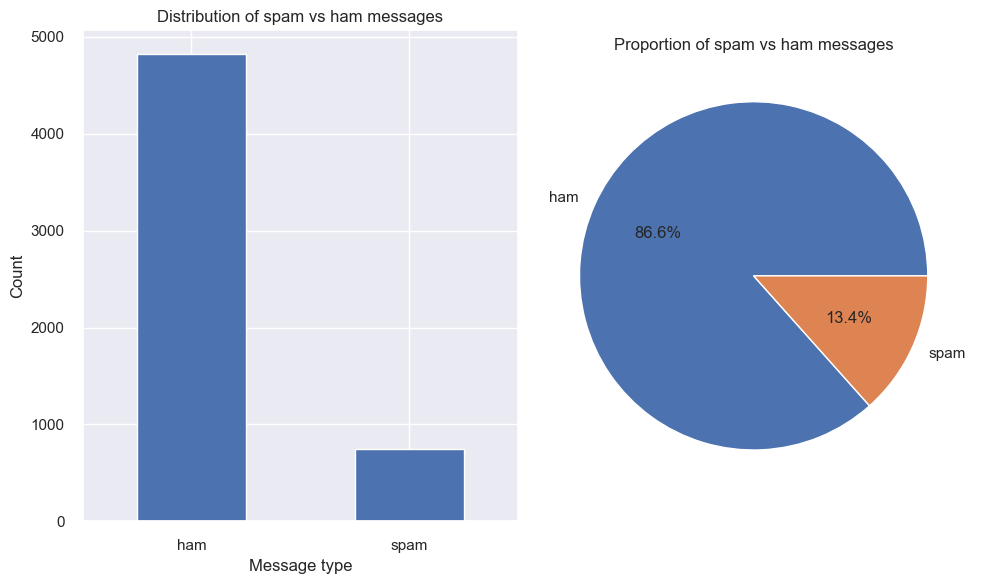

In [103]:
# 2.1 Explore data patterns and distributions

# Visualize the target distribution
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
df["v1"].value_counts().plot(kind="bar")
plt.title("Distribution of spam vs ham messages")
plt.xlabel("Message type")
plt.ylabel("Count")
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df["v1"].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.title("Proportion of spam vs ham messages")
plt.ylabel("")

plt.tight_layout()
plt.show()



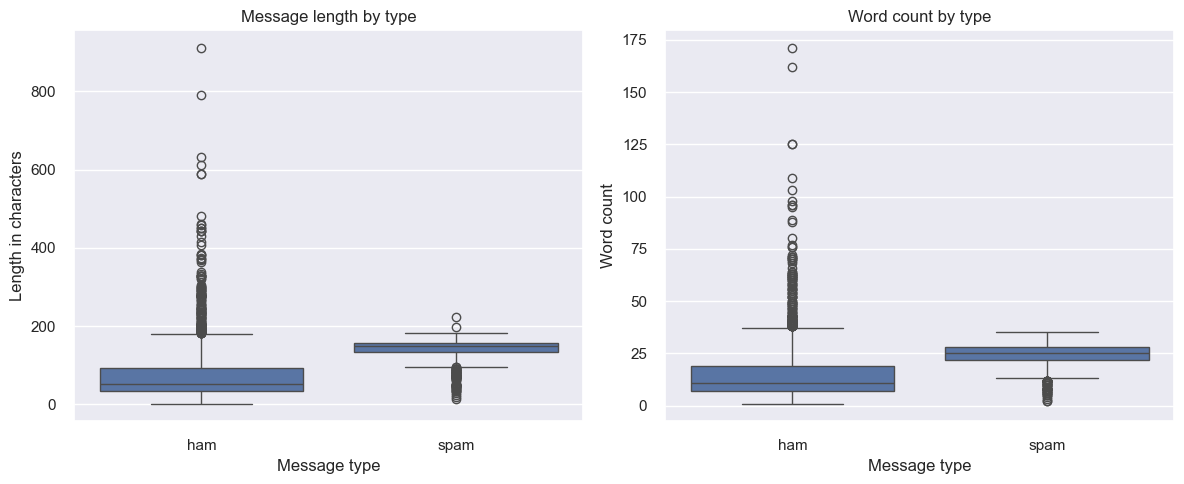

In [104]:
# Analyze message length characteristics
df["message_length"] = df["v2"].apply(len)
df["word_count"] = df["v2"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x="v1", y="message_length", data=df)
plt.title("Message length by type")
plt.xlabel("Message type")
plt.ylabel("Length in characters")

plt.subplot(1, 2, 2)
sns.boxplot(x="v1", y="word_count", data=df)
plt.title("Word count by type")
plt.xlabel("Message type")
plt.ylabel("Word count")

plt.tight_layout()
plt.show()



In [105]:
print("Message length statistics by type:")
display(df.groupby("v1")["message_length"].describe())


Message length statistics by type:


,count,mean,std,min,25%,50%,75%,max
v1,,,,,,,,
ham,4825.0,71.023627,58.016023,2.0,33.0,52.0,92.0,910.0
spam,747.0,138.866131,29.183082,13.0,132.5,149.0,157.0,224.0


Word cloud for spam messages:


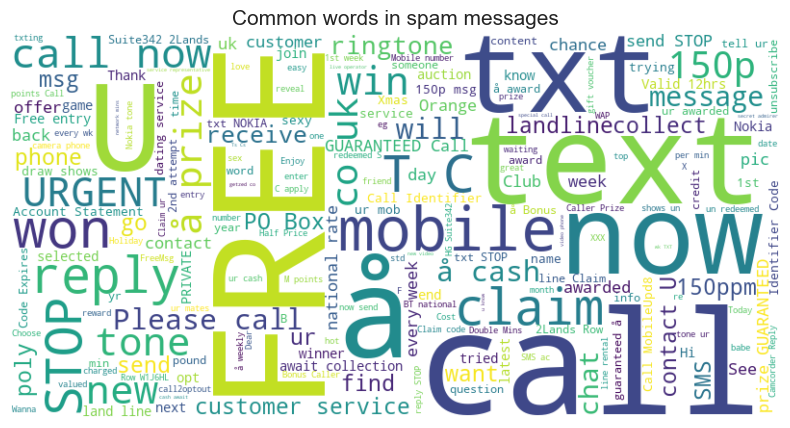

Word cloud for ham messages:


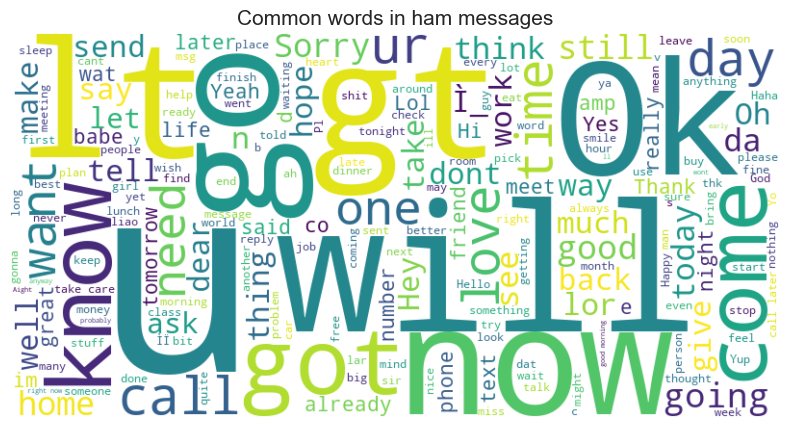

In [106]:
# Create word clouds for spam and ham messages

def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title, size=15)
    plt.axis("off")
    plt.show()

spam_messages = " ".join(df[df["v1"] == "spam"]["v2"].astype(str).tolist())
ham_messages = " ".join(df[df["v1"] == "ham"]["v2"].astype(str).tolist())

print("Word cloud for spam messages:")
create_wordcloud(spam_messages, "Common words in spam messages")

print("Word cloud for ham messages:")
create_wordcloud(ham_messages, "Common words in ham messages")


### 2.2 Handle missing values and clean data


In [107]:
# 2.2 Handle missing values and clean data

# Keep only the label and message columns and rename them
df_clean = df[["v1", "v2"]].copy()
df_clean.columns = ["label", "message"]

print("Missing values after selecting relevant columns:")
print(df_clean.isnull().sum())



Missing values after selecting relevant columns:
label      0
message    0
dtype: int64


In [108]:
# Drop any row with missing label or message just in case
df_clean = df_clean.dropna(subset=["label", "message"]).copy()

# Text preprocessing function
def preprocess_text(text):
    text = str(text).lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    text = " ".join(text.split())
    return text

# Apply text preprocessing
df_clean["cleaned_message"] = df_clean["message"].apply(preprocess_text)

print("\nSample of original vs cleaned messages:")
print("Original:", df_clean["message"].iloc[0])
print("Cleaned:", df_clean["cleaned_message"].iloc[0])



Sample of original vs cleaned messages:
Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Cleaned: go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat


### 2.3 Feature selection and engineering


In [109]:
# 2.3 Feature selection and engineering

df_clean["message_length"] = df_clean["message"].apply(len)
df_clean["word_count"] = df_clean["message"].apply(lambda x: len(str(x).split()))
df_clean["avg_word_length"] = df_clean["message_length"] / df_clean["word_count"]
df_clean["has_currency"] = df_clean["message"].apply(
    lambda x: 1 if any(char in str(x) for char in ["$", "£", "€"]) else 0
)
df_clean["has_numbers"] = df_clean["message"].apply(
    lambda x: 1 if re.search(r"\d", str(x)) else 0
)
df_clean["has_urgent_words"] = df_clean["message"].apply(
    lambda x: 1
    if any(
        word in str(x).lower()
        for word in ["urgent", "free", "winner", "prize", "cash", "claim"]
    )
    else 0
)

# Encode the target variable (0 = ham, 1 = spam)
le = LabelEncoder()
df_clean["label_encoded"] = le.fit_transform(df_clean["label"])

print("New features created (first five rows):")
display(
    df_clean[
        [
            "message_length",
            "word_count",
            "avg_word_length",
            "has_currency",
            "has_numbers",
            "has_urgent_words",
            "label_encoded",
        ]
    ].head()
)


New features created (first five rows):


,message_length,word_count,avg_word_length,has_currency,has_numbers,has_urgent_words,label_encoded
0,111,20,5.550000,0,0,0,0
1,29,6,4.833333,0,0,0,0
2,155,28,5.535714,0,1,1,1
3,49,11,4.454545,0,0,0,0
4,61,13,4.692308,0,0,0,0


**Reflection 2**

The exploration shows clear differences between spam and ham messages. Spam messages tend to be longer, contain more words, and frequently include numbers and currency symbols. The word clouds also show that spam uses vocabulary related to prizes, cash, and urgent offers, while ham messages contain more conversational language.

The cleaning steps included removing unused columns, dropping missing values, and standardizing the text by lowercasing, removing punctuation, and removing numbers. I also engineered features such as message length, word count, average word length, presence of currency symbols, presence of digits, and urgent words. These features capture patterns that are common in spam messages and should provide useful signal for the classifiers.


## Section 3. Feature Selection and Justification

### 3.1 Choose features and target

### 3.2 Define X and y


In [110]:
# 3.1 and 3.2 Choose features and define X and y

# Text features: TF IDF of cleaned messages
X_text = df_clean["cleaned_message"]

# Engineered numeric features
X_engineered = df_clean[
    ["message_length", "word_count", "has_currency", "has_numbers", "has_urgent_words"]
]

# Target variable
y = df_clean["label_encoded"]

print("Shape of engineered features:", X_engineered.shape)
print("\nTarget variable distribution:")
display(y.value_counts())


Shape of engineered features: (5572, 5)

Target variable distribution:


label_encoded
0    4825
1     747
Name: count, dtype: int64

**Reflection 3**

I decided to combine two kinds of features. First, the cleaned message text is converted into TF IDF features so that the model can use important words and short phrases. Second, I include engineered numeric features such as message length, word count, and indicators for currency symbols, numbers, and urgent words. 

The text features capture detailed content of each message, while the engineered features summarize strong patterns that were visible during exploration. Together, these choices should help the models distinguish promotional or fraudulent messages from ordinary conversations.


## Section 4. Train a Model

For the first classifier I use a Random Forest model.

### 4.1 Split the data into training and test sets


In [111]:
# 4.1 Split the data into training and test sets
# Use a stratified split to respect the class imbalance

X_train_text, X_test_text, X_train_eng, X_test_eng, y_train, y_test = train_test_split(
    X_text,
    X_engineered,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

print("Training set size:", len(X_train_text))
print("Test set size:", len(X_test_text))
print("\nTraining set class distribution:")
display(y_train.value_counts(normalize=True))


Training set size: 4457
Test set size: 1115

Training set class distribution:


label_encoded
0    0.865829
1    0.134171
Name: proportion, dtype: float64

### 4.2 Train the model

### 4.3 Evaluate performance


TF IDF feature matrix shape: (4457, 5000)
Combined feature matrix shape: (4457, 5005)
Random Forest performance on test set:
Accuracy: 0.9811659192825112
Precision: 0.9705882352941176
Recall: 0.8859060402684564
F1 score: 0.9263157894736842

Classification report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.97      0.89      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



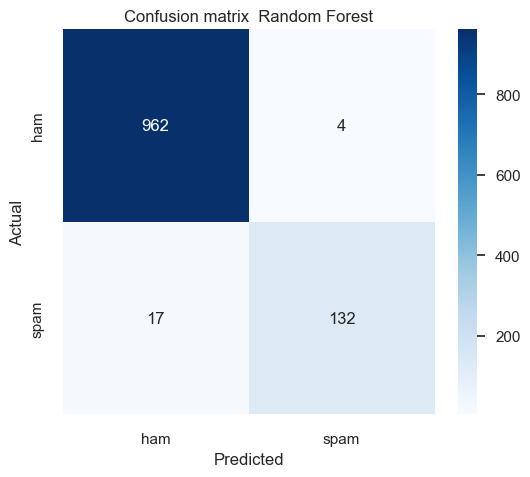

In [112]:
# Vectorize the text data using TF IDF
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words="english",
    ngram_range=(1, 2),
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

print("TF IDF feature matrix shape:", X_train_tfidf.shape)

# Combine TF IDF features with engineered features
X_train_combined = hstack([X_train_tfidf, X_train_eng.values])
X_test_combined = hstack([X_test_tfidf, X_test_eng.values])

print("Combined feature matrix shape:", X_train_combined.shape)

# 4.2 Train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced",
)

rf_model.fit(X_train_combined, y_train)

# 4.3 Evaluate performance
y_pred_rf = rf_model.predict(X_test_combined)

print("Random Forest performance on test set:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 score:", f1_score(y_test, y_pred_rf))

print("\nClassification report:")
print(classification_report(y_test, y_pred_rf, target_names=["ham", "spam"]))

# Confusion matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["ham", "spam"],
    yticklabels=["ham", "spam"],
)
plt.title("Confusion matrix  Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
